In [39]:
import pandas as pd

# Load the uploaded files to inspect their content
population_df = pd.read_csv('population.csv')
obesity_df = pd.read_csv('2011-2012 obesity per ward .csv')

# Merge the two datasets on multiple columns
obesity2011to12 = pd.merge(population_df, obesity_df, on=['MSOA code', 'MSOA name', 'LA code', 'LA name'])

# Remove '%' symbols from all columns in the DataFrame
obesity2011to12 = obesity2011to12.applymap(lambda x: x.replace('%', '') if isinstance(x, str) else x)

obesity2011to12 = obesity2011to12[~obesity2011to12.isin(["s"]).any(axis=1)]
print(obesity2011to12.head())




   MSOA code                 MSOA name    LA code               LA name  \
0  E02000001        City of London 001  E09000001        City of London   
1  E02000002  Barking and Dagenham 001  E09000002  Barking and Dagenham   
2  E02000003  Barking and Dagenham 002  E09000002  Barking and Dagenham   
3  E02000004  Barking and Dagenham 003  E09000002  Barking and Dagenham   
4  E02000005  Barking and Dagenham 004  E09000002  Barking and Dagenham   

  Mid-2014 population  Area Sq Km People per Sq Km  reception sample size  \
0               8,072        2.90            2,786                   81.0   
1               7,235        2.16            3,347                  359.0   
2              10,732        2.14            5,011                  401.0   
3               6,419        2.49            2,575                  208.0   
4               9,056        1.19            7,622                  475.0   

  reception obesity number reception obesity prevalence(%)  ... upper CI 2  \
0       

/tmp/ipykernel_9470/1180274258.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  obesity2011to12 = obesity2011to12.applymap(lambda x: x.replace('%', '') if isinstance(x, str) else x)


In [40]:
# Convert 'People per Sq Km' column to numeric for calculations, removing any commas
obesity2011to12['People per Sq Km'] = obesity2011to12['People per Sq Km'].str.replace(',', '').astype(float)

# Calculate the 25th, 50th, and 75th percentiles
percentiles = obesity2011to12['People per Sq Km'].quantile([0.25, 0.5, 0.75])

percentiles


0.25     4860.25
0.50     7537.00
0.75    11921.00
Name: People per Sq Km, dtype: float64

In [41]:
obesity2011to12.info()


<class 'pandas.core.frame.DataFrame'>
Index: 942 entries, 0 to 982
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   MSOA code                        942 non-null    object 
 1   MSOA name                        942 non-null    object 
 2   LA code                          942 non-null    object 
 3   LA name                          942 non-null    object 
 4   Mid-2014 population              942 non-null    object 
 5   Area Sq Km                       942 non-null    float64
 6   People per Sq Km                 942 non-null    float64
 7   reception sample size            942 non-null    float64
 8   reception obesity number         942 non-null    object 
 9   reception obesity prevalence(%)  942 non-null    object 
 10  lower CI                         942 non-null    object 
 11  upper CI                         942 non-null    object 
 12  Unnamed: 9                 

In [42]:
columns_to_convert = ['Mid-2014 population', 'reception obesity number', 
                      'reception obesity prevalence(%)', 'lower CI', 
                      'upper CI', 'year 6 obesity number', 
                      'year 6 obesity prevalence', 'lower CI 2', 'upper CI 2']

for col in columns_to_convert:
    obesity2011to12[col] = obesity2011to12[col].str.replace('%', '').str.replace(',', '').astype(float)

In [58]:
# Define urban and suburban areas based on the threshold of 4860 people per sq km
obesity2011to12['Area Type'] = obesity2011to12['People per Sq Km'].apply(lambda x: 'Suburban' if x <= 4860 else 'Urban')

area_type_counts = obesity2011to12['Area Type'].value_counts()
print(area_type_counts)

# Calculate the average obesity prevalence for reception and year 6 in urban and suburban areas
#avg_obesity_reception = obesity2011to12.groupby('Area Type')['reception obesity prevalence(%)'].mean()
#avg_obesity_year6 = obesity2011to12.groupby('Area Type')['year 6 obesity prevalence'].mean()

#avg_obesity_reception, avg_obesity_year6


Area Type
Urban       706
Suburban    236
Name: count, dtype: int64


In [59]:
# Create a new column 'Not Obese' by calculating 100 minus the 'reception obesity prevalence(%)'
obesity2011to12['reception without obesity(%)'] = 100 - obesity2011to12['reception obesity prevalence(%)']
obesity2011to12['year6 without obesity(%)'] = 100 - obesity2011to12['year 6 obesity prevalence']

# Display the first few rows to confirm the new column
obesity2011to12[['Area Type', 'reception obesity prevalence(%)', 'reception without obesity(%)']].head()

avg_obesity_rate = obesity2011to12["reception obesity prevalence(%)"].mean()
avg_without_obesity_rate = obesity2011to12["reception without obesity(%)"].mean()
avg_without_obesity_rate2 = obesity2011to12["year6 without obesity(%)"].mean()

avg_obesity_rate, avg_without_obesity_rate, avg_without_obesity_rate2

obesity2011to12.to_csv('obesity2011to12.csv', index=False) 


In [69]:
summary = obesity2011to12.groupby(['Area Type'])[['reception obesity number', 'year 6 obesity number']].agg(['mean', 'sum', 'count', 'std'])
print(summary)

          reception obesity number                            \
                              mean      sum count        std   
Area Type                                                      
Suburban                 28.411017   6705.0   236  19.457005   
Urban                    32.892351  23222.0   706  17.537632   

          year 6 obesity number                            
                           mean      sum count        std  
Area Type                                                  
Suburban              47.385593  11183.0   236  25.779582  
Urban                 55.103399  38903.0   706  26.939740  


In [71]:
obesity2011to12['reception not obese'] = obesity2011to12['reception sample size'] - obesity2011to12['reception obesity number']
obesity2011to12['year 6 not obese'] = obesity2011to12['year 6 sample size '] - obesity2011to12['year 6 obesity number']

summary = obesity2011to12.groupby(['Area Type'])[['reception not obese', 'year 6 not obese']].agg(['mean', 'sum', 'count', 'std'])
print(summary)

          reception not obese                            year 6 not obese  \
                         mean       sum count        std             mean   
Area Type                                                                   
Suburban           252.894068   59683.0   236  90.283675       185.139831   
Urban              260.467422  183890.0   706  92.972441       181.215297   

                                      
                sum count        std  
Area Type                             
Suburban    43693.0   236  59.426135  
Urban      127938.0   706  67.160729  


In [11]:
import statsmodels
print(statsmodels.__version__) 

0.14.3


In [18]:
import statsmodels.api as sm
from statsmodels.stats.contingency_tables import mantelhaenszel

ImportError: cannot import name 'mantelhaenszel' from 'statsmodels.stats.contingency_tables' (/opt/conda/lib/python3.11/site-packages/statsmodels/stats/contingency_tables.py)

In [21]:
import numpy as np
from scipy.stats import chi2_contingency

#Observed data from the image (Reception year data only)
observed = np.array([[23222, 6705],
                     [183890, 59683]])

# Perform chi-squared test
chi2, p, dof, expected = chi2_contingency(observed)

print("Pearson's Chi-squared Test (Reception Year):")
print("Chi-squared statistic:", chi2)
print("P-value:", p)
print("Degrees of freedom:", dof)
print("\nExpected Frequencies:\n", expected)

#Observed data from the image (Year 6 data only)
observed_year6 = np.array([[38903, 11183],
                           [127938, 43693]])

# Perform chi-squared test for year 6 data
chi2_year6, p_year6, dof_year6, expected_year6 = chi2_contingency(observed_year6)

print("\nPearson's Chi-squared Test (Year 6):")
print("Chi-squared statistic:", chi2_year6)
print("P-value:", p_year6)
print("Degrees of freedom:", dof_year6)
print("\nExpected Frequencies:\n", expected_year6)

Pearson's Chi-squared Test (Reception Year):
Chi-squared statistic: 63.74424035882687
P-value: 1.416671464378661e-15
Degrees of freedom: 1

Expected Frequencies:
 [[ 22662.672117   7264.327883]
 [184449.327883  59123.672117]]

Pearson's Chi-squared Test (Year 6):
Chi-squared statistic: 203.76798417551277
P-value: 3.1449282917392126e-46
Degrees of freedom: 1

Expected Frequencies:
 [[ 37689.47949864  12396.52050136]
 [129151.52050136  42479.47949864]]


In [25]:
from statsmodels.stats.contingency_tables import StratifiedTable

# Create a list of contingency tables for each stratum (age group)
tables = [
    [[30, 70], [20, 80]],  # Young
    [[20, 80], [10, 90]]   # Old
]

# Perform the Mantel–Haenszel test
mh_test = StratifiedTable(tables)
result = mh_test.test_null_odds()

# Access and print the results
mh_stat = result.statistic
p_value = result.pvalue

print(f"Mantel–Haenszel statistic: {mh_stat}")
print(f"p-value: {p_value}")

Mantel–Haenszel statistic: 6.317460317460318
p-value: 0.011955474072653405


In [27]:
from statsmodels.stats.contingency_tables import StratifiedTable

# Create a list of contingency tables for each stratum (age group)
tables = [
    [[23222, 183890], [6705, 59683]],  # Young
    [[38903, 127938], [11183, 43693]]   # Old
]

# Perform the Mantel–Haenszel test
mh_test = StratifiedTable(tables)
result = mh_test.test_null_odds()

# Access and print the results
mh_stat = result.statistic
p_value = result.pvalue

print(f"Mantel–Haenszel statistic: {mh_stat}")
print(f"p-value: {p_value}")

Mantel–Haenszel statistic: 259.3187098918548
p-value: 0.0


In [133]:
import pandas as pd
import numpy as np
# import other factors dataset

supermarket = pd.read_csv('Counts of Supermarket.csv')
obesity = pd.read_csv('obesity.csv')
sport_facilities = pd.read_csv('Counts of publicly accessible sports facilities 10,000 people.csv')
poverty = pd.read_csv('children in poverty.csv')
uneducated = pd.read_csv('no education.csv')

# Merge DataFrames (chained merge)
obesity2 = pd.merge(supermarket, obesity, on=['MSOA code','MSOA name'] , how='left')
obesity2 = pd.merge(obesity2, sport_facilities, on=['MSOA code','MSOA name'] , how='left')
obesity2 = pd.merge(obesity2, poverty, on=['LA code','LA name'] , how='left')
obesity2 = pd.merge(obesity2, uneducated, on='LA name' , how='left')

columns_to_convert = ['People per facility', 'CTC all children','CTC under 16', 'child benefit under 16', 'child benefit all children','under 16 in low income', 'all children in low income']

for col in columns_to_convert:
    # 1. Handle missing values: Replace ' NA ' with np.nan
    obesity2[col] = obesity2[col].replace(' NA ', np.nan)

    # 2. Remove percentage signs and commas:
    obesity2[col] = obesity2[col].astype(str).str.replace('%', '', regex=False).str.replace(',', '', regex=False)

    # 3. Convert to numeric (handling potential errors):
    obesity2[col] = pd.to_numeric(obesity2[col], errors='coerce')

obesity2 = obesity2.loc[:, ~obesity2.columns.str.startswith('Unnamed')]
print(obesity2.head())
obesity2.to_csv('obesity2.csv', index=False)

   MSOA code                 MSOA name  Supermarket Count    LA code  \
0  E02000001        City of London 001                 32  E09000001   
1  E02000002  Barking and Dagenham 001                  1  E09000002   
2  E02000003  Barking and Dagenham 002                  2  E09000002   
3  E02000004  Barking and Dagenham 003                  1  E09000002   
4  E02000005  Barking and Dagenham 004                  3  E09000002   

                LA name  Mid-2014 population  Area Sq Km  People per Sq Km  \
0        City of London               8072.0        2.90            2786.0   
1  Barking and Dagenham               7235.0        2.16            3347.0   
2  Barking and Dagenham              10732.0        2.14            5011.0   
3  Barking and Dagenham               6419.0        2.49            2575.0   
4  Barking and Dagenham               9056.0        1.19            7622.0   

   reception sample size  reception obesity number  ...  Facilities Counts  \
0                   

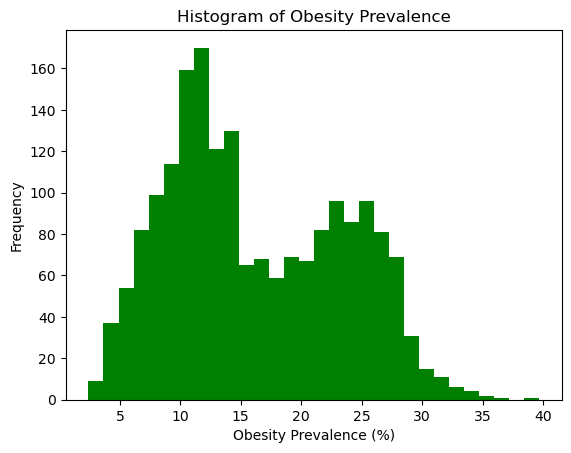

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Combine obesity prevalence data from both age groups
combined_prevalence = pd.concat([obesity['reception obesity prevalence(%)'], obesity['year 6 obesity prevalence']], ignore_index=True)


# Create histogram
plt.hist(combined_prevalence, bins=30,color='green',outline=')  # Adjust 'bins' as needed
plt.xlabel('Obesity Prevalence (%)')
plt.ylabel('Frequency')
plt.title('Histogram of Obesity Prevalence')
plt.show()


In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

#Normalised the histogram


import numpy as np
import matplotlib.pyplot as plt

obesity['children obesity number'] = obesity['reception obesity number'] + obesity['year 6 obesity number']
obesity['all children number'] = obesity['reception sample size'] + obesity['year 6 sample size']
obesity['obesity prevalence'] = (obesity['children obesity number'] / obesity['all children number']) * 100
obesity['obesity prevalence'] = obesity['obesity prevalence'].round(1) #round the result



obesity = obesity.filter(regex='^(?!Unnamed).*')

print(obesity.head())



   MSOA code                 MSOA name    LA code               LA name  \
0  E02000001        City of London 001  E09000001        City of London   
1  E02000002  Barking and Dagenham 001  E09000002  Barking and Dagenham   
2  E02000003  Barking and Dagenham 002  E09000002  Barking and Dagenham   
3  E02000004  Barking and Dagenham 003  E09000002  Barking and Dagenham   
4  E02000005  Barking and Dagenham 004  E09000002  Barking and Dagenham   

   Mid-2014 population  Area Sq Km  People per Sq Km  reception sample size  \
0               8072.0        2.90            2786.0                   81.0   
1               7235.0        2.16            3347.0                  359.0   
2              10732.0        2.14            5011.0                  401.0   
3               6419.0        2.49            2575.0                  208.0   
4               9056.0        1.19            7622.0                  475.0   

   reception obesity number  reception obesity prevalence(%)  ...  \
0    

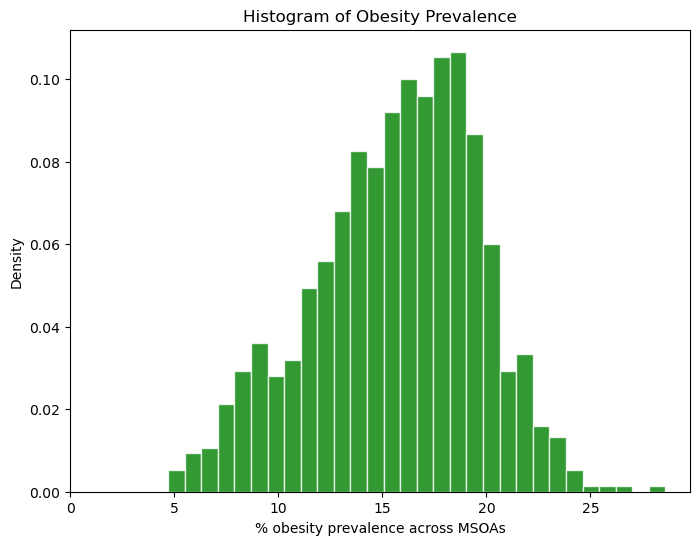

In [93]:
# Combine obesity prevalence data from both age groups
# Normalised the data
combined_prevalence = pd.concat([obesity['reception obesity prevalence(%)'], obesity['year 6 obesity prevalence']], ignore_index=True)
log_transformed = np.log(combined_prevalence + 0.001) #add small value to handle zeros

# Plot the normalized histogram
plt.figure(figsize=(8, 6))
plt.hist(obesity['obesity prevalence'], bins=30, density=True, color='green', edgecolor='white', alpha=0.8)
# Add labels and title
plt.xlabel('% obesity prevalence across MSOAs')
plt.ylabel('Density')
plt.title('Histogram of Obesity Prevalence')
plt.xticks(np.arange(0, 30, 5))
# Show the plot
#plt.show()
plt.savefig('histogram.png', dpi=300)

/tmp/ipykernel_130/600372952.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(percentiles))


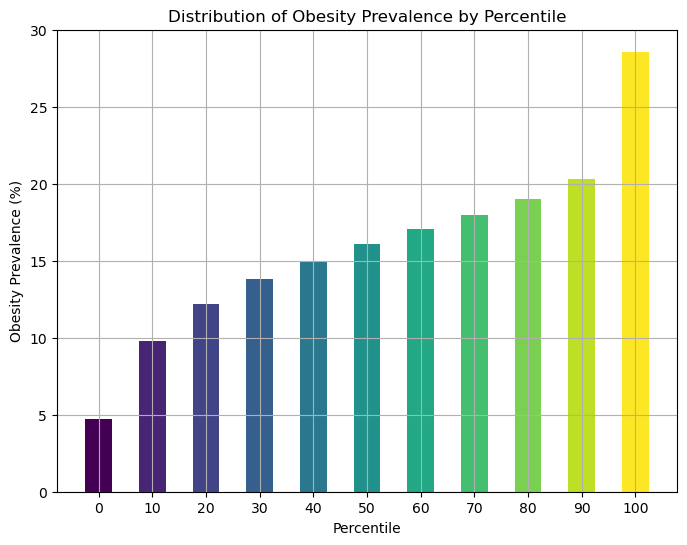

In [102]:
#plot out the distribution of obesity by percentile share
# Calculate percentiles and cumulative shares
import matplotlib.cm as cm
percentiles = np.linspace(0, 100, 11) # 11 percentiles (0, 10, 20, ..., 100)
percentile_values = obesity['obesity prevalence'].quantile(percentiles / 100)
cumulative_shares = obesity['obesity prevalence'].value_counts(normalize=True).sort_index().cumsum()

cmap = cm.get_cmap('viridis', len(percentiles))
# Create the plot
plt.figure(figsize=(8, 6))
colors = cmap(np.linspace(0, 1, len(percentiles)))
plt.bar(percentiles, percentile_values,width=5, color=colors)
plt.xlabel('Percentile')
plt.ylabel('Obesity Prevalence (%)')
plt.title('Distribution of Obesity Prevalence by Percentile')
plt.xticks(percentiles)
plt.grid(True)
#plt.show()
plt.savefig('distribution.png', dpi=300)

In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

#Normalised the histogram


import numpy as np
import matplotlib.pyplot as plt

obesity2['children obesity number'] = obesity2['reception obesity number'] + obesity2['year 6 obesity number']
obesity2['all children number'] = obesity2['reception sample size'] + obesity2['year 6 sample size']
obesity2['obesity prevalence'] = (obesity2['children obesity number'] / obesity2['all children number']) * 100
obesity2['obesity prevalence'] = obesity2['obesity prevalence'].round(1) #round the result



obesity2 = obesity2.filter(regex='^(?!Unnamed).*')

print(obesity2.head())
obesity2.to_csv('obesity2.csv', index=False)

   MSOA code                 MSOA name  Supermarket Count    LA code  \
0  E02000001        City of London 001                 32  E09000001   
1  E02000002  Barking and Dagenham 001                  1  E09000002   
2  E02000003  Barking and Dagenham 002                  2  E09000002   
3  E02000004  Barking and Dagenham 003                  1  E09000002   
4  E02000005  Barking and Dagenham 004                  3  E09000002   

                LA name  Mid-2014 population  Area Sq Km  People per Sq Km  \
0        City of London               8072.0        2.90            2786.0   
1  Barking and Dagenham               7235.0        2.16            3347.0   
2  Barking and Dagenham              10732.0        2.14            5011.0   
3  Barking and Dagenham               6419.0        2.49            2575.0   
4  Barking and Dagenham               9056.0        1.19            7622.0   

   reception sample size  reception obesity number  ...  CTC under 16  \
0                   81.0 

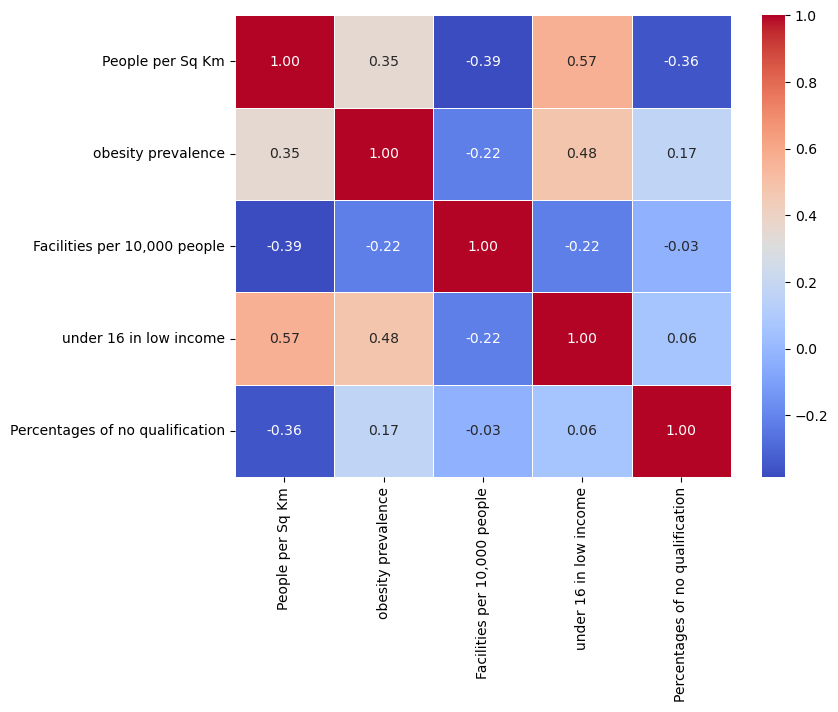

In [142]:
# Select relevant columns for the correlation heatmap
import seaborn as sns
columns_of_interest = [
    "People per Sq Km",
    "obesity prevalence",
    "Facilities per 10,000 people",
    "under 16 in low income",
    "Percentages of no qualification"
]

# Ensure columns are numeric and handle missing values
factors = obesity2[columns_of_interest].apply(pd.to_numeric, errors='coerce')
factors = factors.dropna()

# Compute the correlation matrix using Pearson correlation coefficient
pearson_correlation_matrix = factors.corr(method='pearson', numeric_only=True)

# Create a heatmap for the Pearson correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(pearson_correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, linewidths=0.5)

# Show the heatmap
#plt.show()
plt.savefig('correlation matrix.png', dpi=300)

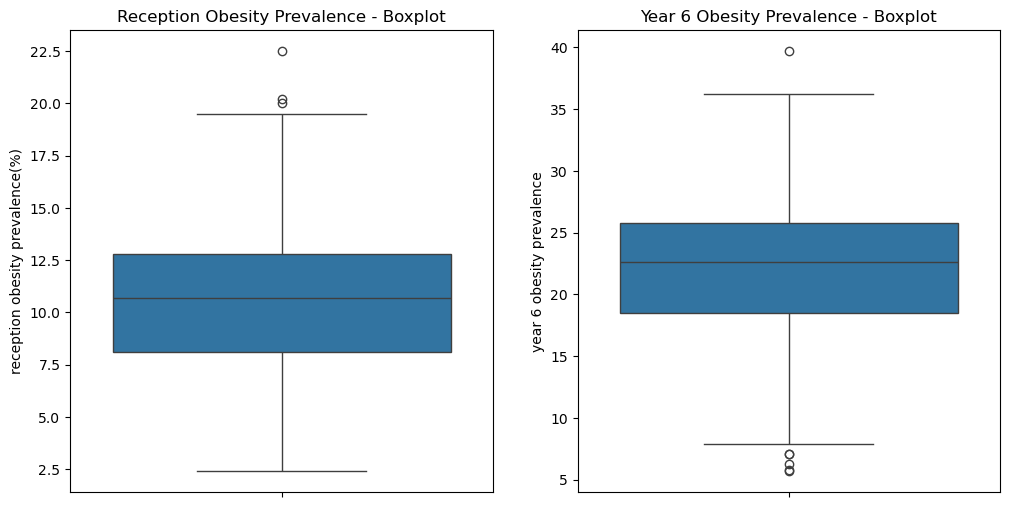

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create boxplots for the two variables
plt.figure(figsize=(12, 6))

# Boxplot for reception obesity prevalence
plt.subplot(1, 2, 1)
sns.boxplot(obesity2['reception obesity prevalence(%)'])
plt.title('Reception Obesity Prevalence - Boxplot')

# Boxplot for year 6 obesity prevalence
plt.subplot(1, 2, 2)
sns.boxplot(obesity2['year 6 obesity prevalence'])
plt.title('Year 6 Obesity Prevalence - Boxplot')

plt.show()

In [146]:
def detect_outliers_with_msoa(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers[['MSOA name', column]]

# Detect outliers for reception obesity prevalence
reception_outliers = detect_outliers_with_msoa(obesity2, 'reception obesity prevalence(%)')
print("Reception Obesity Prevalence Outliers with MSOA name:")
print(reception_outliers)

# Detect outliers for year 6 obesity prevalence
year6_outliers = detect_outliers_with_msoa(obesity2, 'year 6 obesity prevalence')
print("\nYear 6 Obesity Prevalence Outliers with MSOA name:")
print(year6_outliers)

Reception Obesity Prevalence Outliers with MSOA name:
         MSOA name  reception obesity prevalence(%)
324    Hackney 002                             22.5
373   Haringey 002                             20.0
774  Southwark 016                             20.2

Year 6 Obesity Prevalence Outliers with MSOA name:
                    MSOA name  year 6 obesity prevalence
739  Richmond upon Thames 002                        7.1
753  Richmond upon Thames 016                        5.7
756  Richmond upon Thames 019                        7.1
758  Richmond upon Thames 021                        6.3
887            Wandsworth 017                        5.8
919           Westminster 012                       39.7


In [177]:
obesity2 = obesity2[~obesity2['MSOA name'].isin(['Hackney 002', 'Westminster 012','City of London 001'])]

# Remove rows with any missing or empty values
obesity2 = obesity2.dropna()

# Display the cleaned data
print(obesity2.head())
obesity2.to_csv('obesity2.csv', index=False)

   MSOA code                 MSOA name  Supermarket Count    LA code  \
1  E02000002  Barking and Dagenham 001                  1  E09000002   
2  E02000003  Barking and Dagenham 002                  2  E09000002   
3  E02000004  Barking and Dagenham 003                  1  E09000002   
4  E02000005  Barking and Dagenham 004                  3  E09000002   
5  E02000007  Barking and Dagenham 006                  2  E09000002   

                LA name  Mid-2014 population  Area Sq Km  People per Sq Km  \
1  Barking and Dagenham               7235.0        2.16            3347.0   
2  Barking and Dagenham              10732.0        2.14            5011.0   
3  Barking and Dagenham               6419.0        2.49            2575.0   
4  Barking and Dagenham               9056.0        1.19            7622.0   
5  Barking and Dagenham               9398.0        1.74            5414.0   

   reception sample size  reception obesity number  ...  \
1                  359.0               

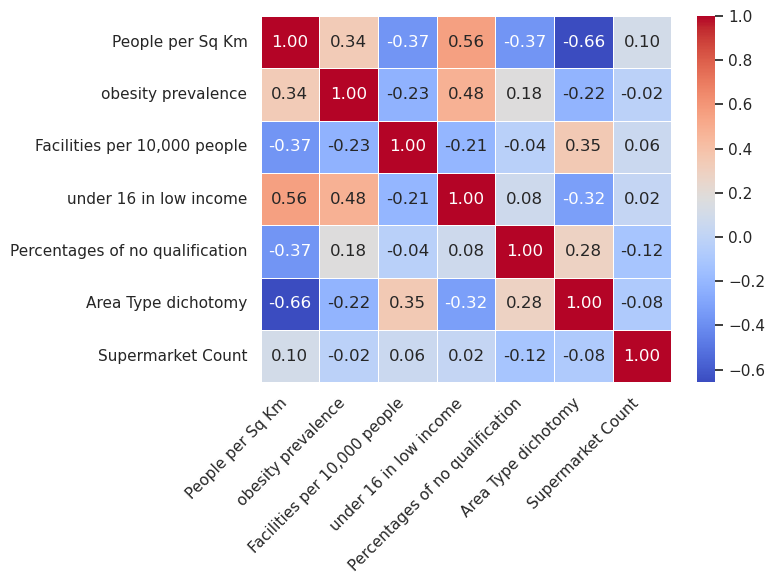

In [249]:
obesity2['Area Type dichotomy'] = obesity2['Area Type'].apply(lambda x: 1 if x.lower() == 'suburban' else 0)
# Select relevant columns for the correlation heatmap
import seaborn as sns
columns_of_interest = [
    "People per Sq Km",
    "obesity prevalence",
    "Facilities per 10,000 people",
    "under 16 in low income",
    "Percentages of no qualification",
    "Area Type dichotomy",
    "Supermarket Count"
]

# Ensure columns are numeric and handle missing values
factors = obesity2[columns_of_interest].apply(pd.to_numeric, errors='coerce')
factors = factors.dropna()

# Compute the correlation matrix using Pearson correlation coefficient
pearson_correlation_matrix = factors.corr(method='pearson', numeric_only=True)

# Create a heatmap for the Pearson correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(pearson_correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, linewidths=0.5)

# Adjust the rotation of x-axis and y-axis labels
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.yticks(rotation=0)               # Keep y-axis labels horizontal

# Adjust the layout to avoid cutting labels
plt.tight_layout()

# Save the figure with a white background
plt.savefig('correlation_matrix.png', dpi=300, facecolor='white', bbox_inches='tight')
#plt.show()

In [151]:
import statsmodels.api as sm
import numpy as np

# Fit a regression model
X = obesity2[['People per Sq Km', 'Facilities per 10,000 people','under 16 in low income','Percentages of no qualification']]  # Replace with your predictors
y = obesity2['obesity prevalence']  # Replace with your target variable
X = sm.add_constant(X)  # Add constant for intercept
model = sm.OLS(y, X).fit()

# Calculate Cook's distance
influence = model.get_influence()
cooks_d, p_values = influence.cooks_distance

# Identify points with high Cook's distance
threshold = 4 / len(data)
high_influence_points = np.where(cooks_d > threshold)

print("High Cook's Distance Points:", high_influence_points)


High Cook's Distance Points: (array([  0,  19,  60,  64,  84, 108, 149, 166, 249, 254, 262, 295, 299,
       310, 329, 338, 344, 346, 381, 432, 457, 463, 481, 490, 566, 609,
       631, 668, 670, 716, 743, 746, 750, 752, 755, 759]),)


   Facilities per 10,000 people  Facilities per 10,000 people (log)
0                        100.20                            4.617099
1                          1.21                            0.792993
2                          4.33                            1.673351
3                         22.59                            3.160823
4                          1.80                            1.029619


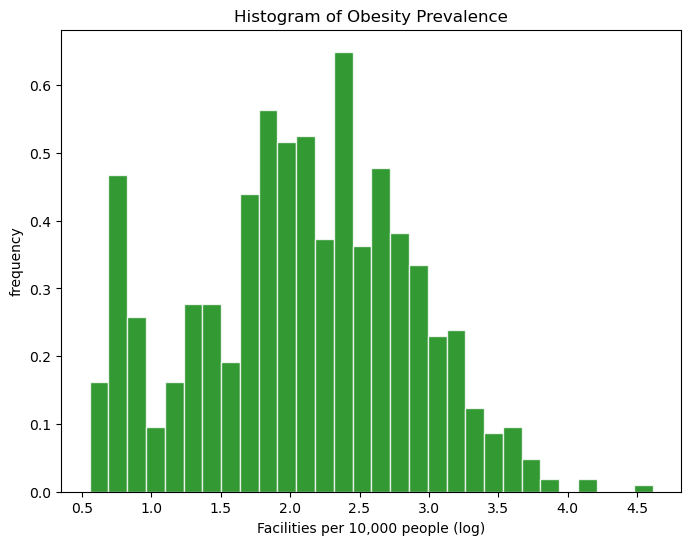

In [169]:
import numpy as np

# Apply log transformation (adding 1 to avoid log(0))
obesity2['Facilities per 10,000 people (log)'] = np.log1p(obesity2['Facilities per 10,000 people'])

# Verify the transformation
print(obesity2[['Facilities per 10,000 people', 'Facilities per 10,000 people (log)']].head())

# Plot the normalized histogram
plt.figure(figsize=(8, 6))
plt.hist(obesity2['Facilities per 10,000 people (log)'], bins=30, density=True, color='green', edgecolor='white', alpha=0.8)
# Add labels and title
plt.xlabel('Facilities per 10,000 people (log)')
plt.ylabel('frequency')
plt.title('Histogram of Obesity Prevalence')
# Show the plot
#plt.show()
plt.savefig('histogram.png', dpi=300)


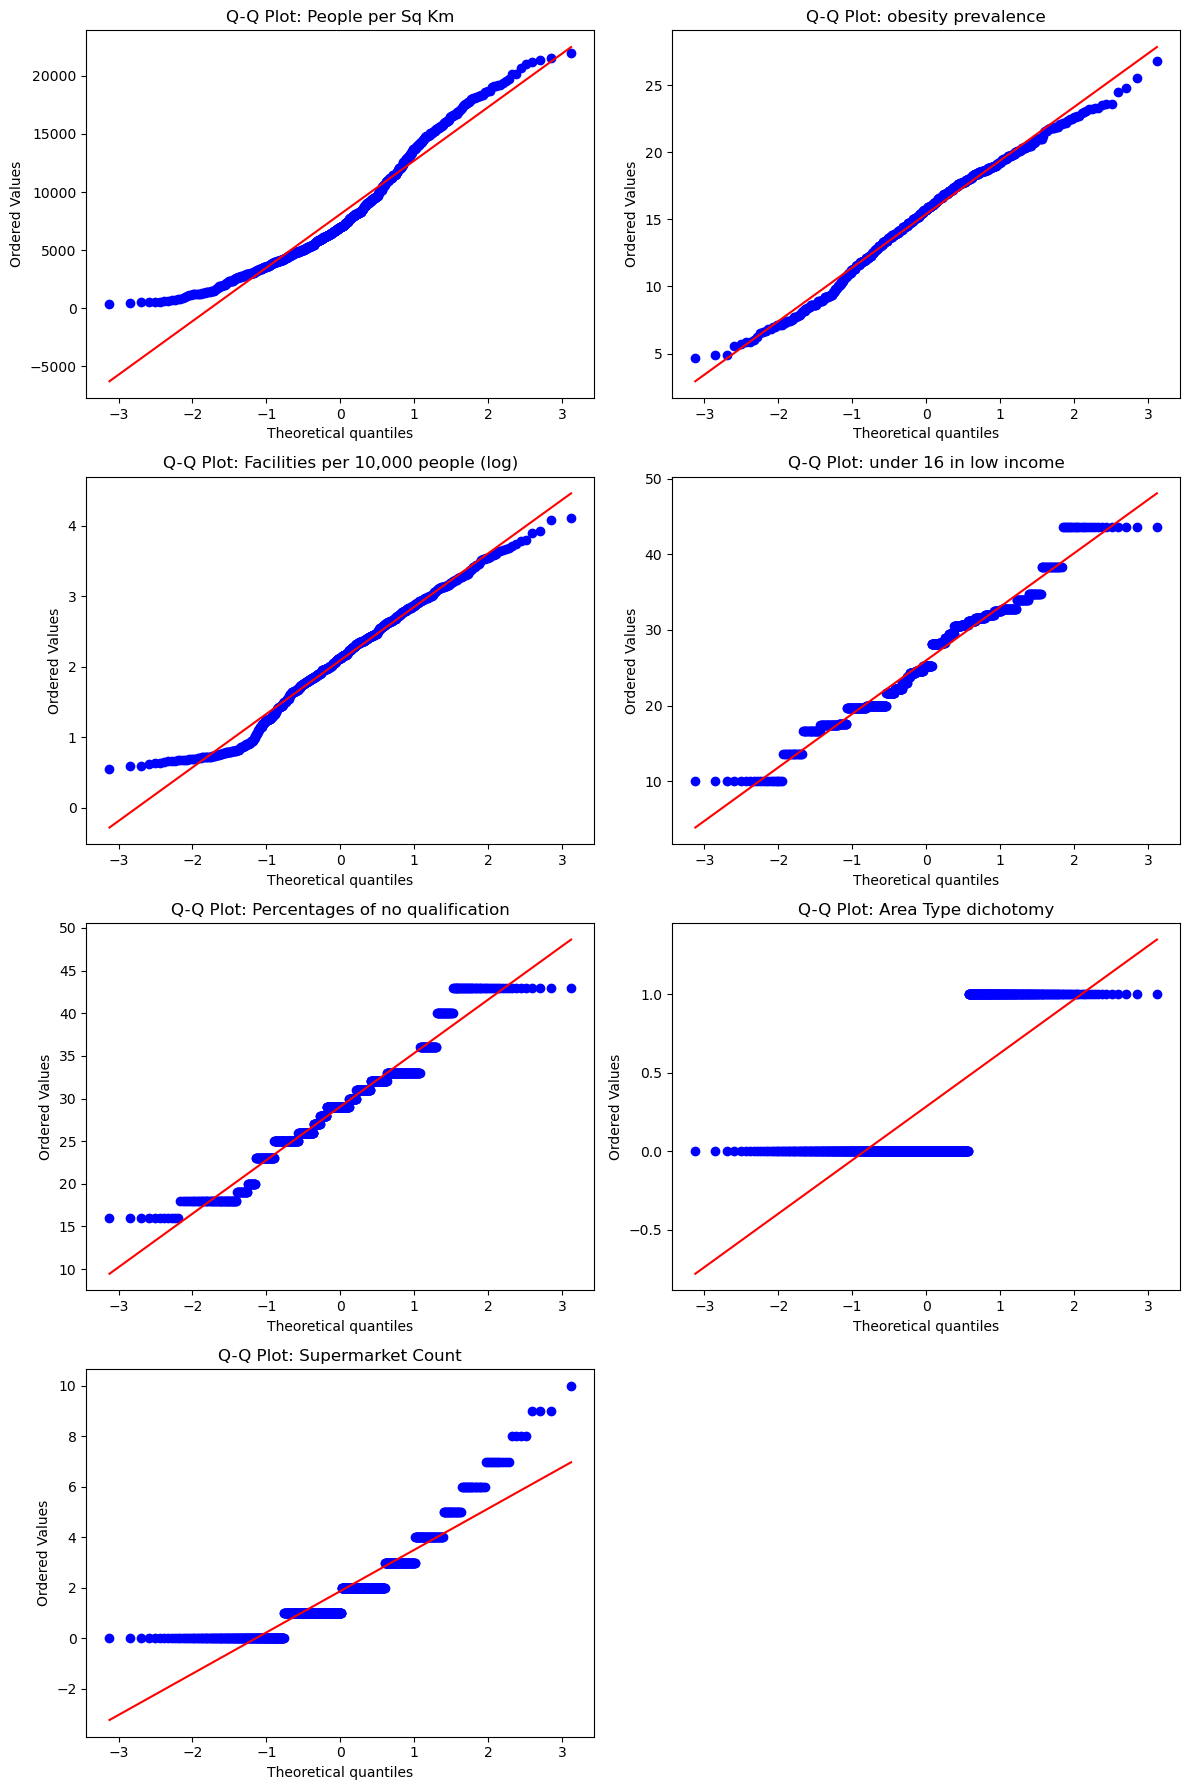

In [181]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# List of columns to analyze
columns = [
    "People per Sq Km",
    "obesity prevalence",
    "Facilities per 10,000 people (log)",
    "under 16 in low income",
    "Percentages of no qualification",
    "Area Type dichotomy",
    "Supermarket Count"
]

# Create Q-Q plots for each column
plt.figure(figsize=(12, 18))  # Set figure size
for i, column in enumerate(columns):
    plt.subplot(4, 2, i + 1)  # Arrange plots in a 3x2 grid
    stats.probplot(obesity2[column].dropna(), dist="norm", plot=plt)  # Q-Q plot
    plt.title(f"Q-Q Plot: {column}")

# Show all Q-Q plots
plt.tight_layout()
plt.show()

In [182]:
columns_to_extract = [
    "People per Sq Km",
    "obesity prevalence",
    "reception obesity prevalence(%)",
    "year 6 obesity prevalence",
    "Facilities per 10,000 people(log)",
    "under 16 in low income",
    "Percentages of no qualification",
    "Area Type",
    "Area Type dichotomy",
    "Supermarket Count"
    
]

# Extract the columns to form a new dataset
obesity3 = obesity2[columns_to_extract]

# Display the first few rows of the new dataset
print(obesity3.head())

   People per Sq Km  obesity prevalence  reception obesity prevalence(%)  \
1            3347.0                17.8                             13.4   
2            5011.0                17.4                             12.2   
3            2575.0                17.1                             14.4   
4            7622.0                16.8                             11.2   
5            5414.0                20.2                             16.1   

   year 6 obesity prevalence  Facilities per 10,000 people (log)  \
1                       24.0                            0.792993   
2                       24.0                            1.673351   
3                       21.0                            3.160823   
4                       24.2                            1.029619   
5                       25.7                            2.929058   

   under 16 in low income  Percentages of no qualification Area Type  \
1                    33.9                             43.0  Su

In [250]:
import pandas as pd
import statsmodels.api as sm

# Define independent and dependent variables
X = obesity2[['Area Type dichotomy', 'Facilities per 10,000 people (log)', 'under 16 in low income', 'Percentages of no qualification']]
y = obesity2['obesity prevalence']

# Add a constant (intercept)
X = sm.add_constant(X)

# Fit the multiple regression model
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())

# Make predictions
predictions = model.predict(X)
print(predictions.head())



                            OLS Regression Results                            
Dep. Variable:     obesity prevalence   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     73.15
Date:                Tue, 14 Jan 2025   Prob (F-statistic):           1.61e-52
Time:                        15:50:50   Log-Likelihood:                -2039.9
No. Observations:                 772   AIC:                             4090.
Df Residuals:                     767   BIC:                             4113.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [251]:
import statsmodels.api as sm

# Define independent and dependent variables
X = obesity2[['Area Type dichotomy', 'Facilities per 10,000 people (log)', 'under 16 in low income', 'Percentages of no qualification']]
X = sm.add_constant(X)  # Add intercept
y = obesity2['obesity prevalence']

# Fit the OLS model
model = sm.OLS(y, X).fit(cov_type='HC3')  # Use HC3 for heteroskedasticity-consistent standard errors

# Print the summary with robust standard errors
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     obesity prevalence   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     84.71
Date:                Tue, 14 Jan 2025   Prob (F-statistic):           1.38e-59
Time:                        15:52:48   Log-Likelihood:                -2039.9
No. Observations:                 772   AIC:                             4090.
Df Residuals:                     767   BIC:                             4113.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

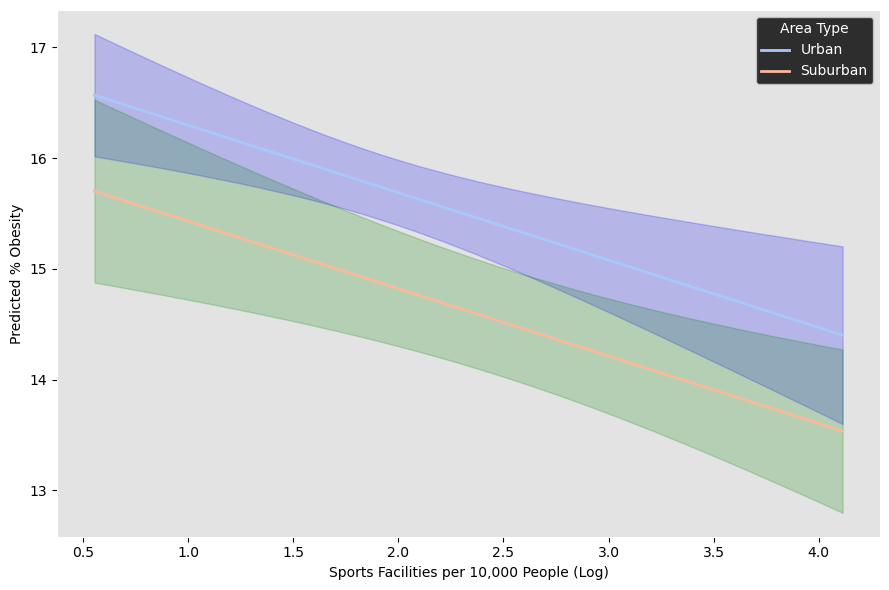

In [243]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define independent and dependent variables
X = obesity2[['Area Type dichotomy', 'Facilities per 10,000 people (log)', 'under 16 in low income', 'Percentages of no qualification']]
y = obesity2['obesity prevalence']

# Add a constant (intercept)
X = sm.add_constant(X)

# Fit the multiple regression model
model = sm.OLS(y, X).fit()

# Generate a range of values for one of the predictors (e.g., 'Facilities per 10,000 people (log)')
facilities_range = np.linspace(X['Facilities per 10,000 people (log)'].min(), X['Facilities per 10,000 people (log)'].max(), 100)

# Fix the other predictors at their mean or specific values
area_type = [0, 1]  # Urban (0) and Suburban (1)
income = X['under 16 in low income'].mean()  # Fix income at its mean
no_qualification = X['Percentages of no qualification'].mean()  # Fix at mean

# Create DataFrame for predictions
predictions = []
for at in area_type:
    for fac in facilities_range:
        temp_df = pd.DataFrame({
            'const': 1,
            'Area Type dichotomy': at,
            'Facilities per 10,000 people (log)': fac,
            'under 16 in low income': income,
            'Percentages of no qualification': no_qualification
        }, index=[0])
        pred = model.get_prediction(temp_df)
        temp_pred = temp_df.copy()
        temp_pred['Predicted'] = pred.predicted_mean
        lower, upper = pred.conf_int(alpha=0.05)[0]  # Extract confidence intervals
        temp_pred['Lower CI'] = lower
        temp_pred['Upper CI'] = upper
        temp_pred['Area Type'] = 'Suburban' if at == 1 else 'Urban'
        predictions.append(temp_pred)

# Combine all predictions
predictions_df = pd.concat(predictions)

# Set custom light grey background
fig, ax = plt.subplots(figsize=(9, 6))
fig.patch.set_facecolor('#ffffff')  # Light grey background for the figure
ax.set_facecolor('#e3e3e3')         # Light grey background for the plot area

# Adjust axis and tick label colors to black
ax.tick_params(axis='x', colors='black')  # X-axis tick labels
ax.tick_params(axis='y', colors='black')  # Y-axis tick labels
ax.spines['bottom'].set_color('white')    # X-axis line
ax.spines['left'].set_color('white')      # Y-axis line


# Plot the thick orange outline
for at in area_type:
    subset = predictions_df[predictions_df['Area Type'] == ('Suburban' if at == 1 else 'Urban')]
    plt.plot(
        subset['Facilities per 10,000 people (log)'],
        subset['Predicted'],
        alpha=0.7,  # Semi-transparent for the outline effect
    )

# Plot the actual lines (layered on top)
sns.lineplot(
    data=predictions_df,
    x='Facilities per 10,000 people (log)',
    y='Predicted',
    hue='Area Type',
    palette='coolwarm',
    linewidth=2
)

# Add confidence intervals with different colors for each area type
for at in area_type:
    subset = predictions_df[predictions_df['Area Type'] == ('Suburban' if at == 1 else 'Urban')]
    ci_color = 'blue' if at == 0 else 'green'  # Blue for Urban, Green for Suburban
    plt.fill_between(
        subset['Facilities per 10,000 people (log)'],
        subset['Lower CI'],
        subset['Upper CI'],
        alpha=0.2,
        color=ci_color
    )

# Customize labels and title
plt.xlabel('Sports Facilities per 10,000 People (Log)', color='black')
plt.ylabel('Predicted % Obesity', color='black')
plt.legend(title='Area Type')

# Adjust layout to remove padding
plt.tight_layout()

# Save the figure with a higher resolution
fig.savefig('clean_figure.png', dpi=300, transparent=False, bbox_inches='tight', facecolor='white')
